<a href="https://colab.research.google.com/github/csoledd/adolmoi/blob/main/INTELIGENCIA_DE_NEGOCIOS_Catalina_N%C3%BA%C3%B1ez_Y%C3%A1%C3%B1ez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Asignatura:** Inteligencia de Negocios

**Estudiante:** Catalina Soledad Núñez Yañez

**Archivo base:** outfits.csv

**Objetivo**

Evaluar cómo ha evolucionado la cantidad de publicaciones de prendas a lo largo del tiempo, usando la variable timeCreated como base temporal, y analizar la frecuencia de registros por año.

**Hipótesis**

+ **Hipótesis nula (H₀):** No ha habido cambios significativos en la cantidad de publicaciones a lo largo del tiempo.

+ **Hipótesis alternativa (H₁):** La cantidad de publicaciones ha mostrado una tendencia creciente o decreciente con el paso del tiempo.

**Abstract**

Este análisis utiliza el dataset outfits.csv, que contiene más de 15.000 registros de prendas, cada una con su respectiva fecha de creación (timeCreated). El objetivo es determinar si la cantidad de publicaciones ha aumentado o disminuido con el paso del tiempo. Se realiza una exploración temporal de la frecuencia de registros por año, mediante visualizaciones y conteos agrupados, para identificar patrones de crecimiento o estancamiento en la actividad de publicación de prendas. Los resultados muestran una clara tendencia creciente hasta el año 2022, seguida de una baja, lo que podría estar asociado a cambios en la actividad comercial, en la plataforma o en el contexto general.

**Metodología**

Carga y limpieza: parseo de timeCreated, conversión de precios a numérico, revisión de nulos.

Descriptivos: media, mediana, moda, rango, varianza, DE, CV, IQR, mínimo/máximo, suma, conteo (para las columnas de precio).

Gráficas obligatorias: histogramas y boxplots de precios.

Dinámica temporal: conteo de altas por mes, línea de tiempo, barras por año, barras por mes del año (estacionalidad) y tabla de crecimiento YoY.

Regresión lineal simple: (a) altas mensuales ~ tiempo y (b) precio ~ tiempo para cada variable de precio.

Interpretación y conclusión.

**Resultados esperados**

Se espera ver una variación visible en la cantidad de registros por año. Si la plataforma fue creciendo en uso, se verá un aumento. Si decayó su uso, veremos una baja en las publicaciones

In [21]:
import numpy as np  # Programación vectorial
import matplotlib.pyplot as plt  # Visualización
import pandas as pd  # Estructura y manipulación de datos
import io  # Módulo io
import seaborn as sns  # Gráficos avanzados
from scipy import stats  # Pruebas estadísticas
from datetime import datetime

# Configuración gráfica básica
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

In [20]:
# 2.1) Subir archivo desde tu PC (Colab). Si usas Jupyter local, salta a la 2.2 y usa PATH.
try:
    from google.colab import files
    uploaded = files.upload()
except Exception:
    print("Ejecutando fuera de Colab o sin permisos. Continúa con la 2.2 y usa PATH manual.")

Saving outfits.csv to outfits (3).csv


In [24]:
# ============================================
# 2.2) Cargar archivo (robusto a separador/encoding)
# --------------------------------------------
# Esta función intenta cargar el CSV ya sea:
#   (A) desde el widget de subida de Colab (dict `uploaded`)
#   (B) desde un archivo local (PATH) si no hay `uploaded`
# Es tolerante a distintos separadores (coma, ;, tab, |)
# y a encodings comunes (utf-8, latin-1). Además, salta filas
# dañadas para que nada detenga la lectura (on_bad_lines='skip').
# ============================================

def cargar_csv_subido(uploaded_dict, prefer='outfits'):
    # ¿Tenemos archivos subidos en Colab?
    if uploaded_dict and len(uploaded_dict) > 0:
        # Lista de nombres de archivos subidos
        keys = list(uploaded_dict.keys())
        # Si hay varios, priorizo el que contenga la palabra 'outfits' (o lo que pase en `prefer`)
        key = next((k for k in keys if prefer.lower() in k.lower()), keys[0])

        # Bytes del archivo elegido
        raw = uploaded_dict[key]

        # Probaré dos encodings típicos en la región
        for enc in ['utf-8', 'latin-1']:
            # Y varios separadores posibles; `None` activa autodetección del separador
            for sep in [None, ',', ';', '\t', '|']:
                try:
                    # Decodifico los bytes a texto con el encoding actual
                    text = raw.decode(enc, errors='ignore')
                    # Lo paso a un buffer tipo archivo para que pandas pueda leerlo
                    buf = io.StringIO(text)

                    # Leo con engine='python' (más flexible con separadores) y
                    # on_bad_lines='skip' para saltar filas problemáticas
                    df_try = pd.read_csv(buf, sep=sep, engine='python', on_bad_lines='skip')

                    # "Sanity check": si hay al menos 3 columnas, asumo que el separador fue correcto
                    if df_try.shape[1] >= 3:
                        print(f"Archivo leído: {key} | encoding={enc} | sep={sep if sep is not None else 'auto'}")
                        return df_try
                except Exception:
                    # Si falla, sigo intentando con la siguiente combinación encoding/separador
                    pass

        # Si ninguna combinación funcionó, aviso explícitamente
        raise ValueError("No se pudo parsear el CSV con encodings/separadores probados.")
    else:
        # --------------------------------------------
        # Modo local (Jupyter/PC): leer desde un PATH
        # --------------------------------------------
        PATH = 'outfits.csv'  # cambia si tu archivo tiene otro nombre
        # sep=None -> que pandas intente detectar el separador automáticamente
        return pd.read_csv(PATH, sep=None, engine='python', on_bad_lines='skip')

# -------------------------------------------------
# Intento cargar según el contexto:
# - En Colab: `uploaded` existe y contiene los bytes
# - En Jupyter local: `uploaded` no existe -> NameError
# -------------------------------------------------
try:
    df = cargar_csv_subido(uploaded)
except NameError:
    df = cargar_csv_subido(None)

# Vista rápida para confirmar que se cargó correctamente
df.head(5)


Archivo leído: outfits (3).csv | encoding=utf-8 | sep=auto


,id,name,description,group,owner,timeCreated,retailPrice,pricePerWeek,pricePerMonth,outfit_tags,tag_categories
0,outfit.fffdaa715c3646f8b1c0f04d549ff07e,Out of stock - Asymmetric Frilled Dress,"This fun, short dress features and asymmetric ...",group.50a586c78eb7626e294ba3bd07d12c79,o_00053,2017-12-30 11:28:01.000,"4,000.00",600.00,"1,200.00","['Synthetic', 'Statement', 'Dresses', 'Metalli...","['Material', 'Occasion', 'Category', 'Details'..."
1,outfit.fffa1b9a3db6415d806f3c48f8ab58d9,Yellow Shell Mellomholmene Blouse,This beautiful blouse features an adjustable n...,group.61ad2fcabb3e9197e3836376e6b67f2c,o_00577,2021-06-07 12:07:22.921,"1,300.00",590.00,"1,180.00","['ILAG', 'Tops', 'Spring', 'Summer', 'M', 'Pat...","['Brand', 'Category', 'Seasons', 'Seasons', 'S..."
2,outfit.fff175b13ceb453f9928625491412ede,Kaula Dress Black,Kaula from Rodebjer is a fitted dress made in ...,group.37c2b59d63d3a9c2d58e07f532f71f7f,o_00336,2023-06-05 09:17:59.004,"3,100.00",930.00,"1,860.00","['Black', 'Mini', 'M', 'Everyday', 'Multi Seas...","['Color', 'Length', 'Size', 'Occasion', 'Seaso..."
3,outfit.ffef9d7c292a48b69076d2df2e32352f,For sale - Jarvis Blouse,This wrap blouse has mid length sleeves and a ...,group.dfcaa57546b0b7a5e9eb204449b6cc1c,o_00030,2021-05-18 14:02:28.690,"1,500.00",590.00,"1,180.00","['XS', 'Multi Season', 'Stylein', 'Tops', 'Cot...","['Size', 'Seasons', 'Brand', 'Category', 'Mate..."
4,outfit.ffeef842238f4dbdabc6c730a75aa2bd,Black Amber Pants,"Feel slack and nice dressed with this pant, ma...",group.ee297c977905eb21a123a4aea5fbb6d2,o_00602,2021-07-16 14:02:30.643,"1,200.00",590.00,"1,180.00","['Cotton', 'Black', 'Everyday', 'Knitwear', 'L...","['Material', 'Color', 'Occasion', 'Category', ..."


In [25]:
# 3) LIMPIEZA BÁSICA + CALIDAD
df['timeCreated'] = pd.to_datetime(df.get('timeCreated'), errors='coerce')

for c in ['retailPrice','pricePerWeek','pricePerMonth']:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

print("Shape:", df.shape)
print("\nDtypes:\n", df.dtypes)
print("\nNulos por columna:\n", df.isnull().sum())

if 'retailPrice' in df.columns:
    p_nulos = 100*df['retailPrice'].isnull().sum()/len(df)
    print(f"\nCalidad -> retailPrice con nulos: {p_nulos:.1f}% (objetivo < 20%)")


Shape: (15649, 11)

Dtypes:
 id                        object
name                      object
description               object
group                     object
owner                     object
timeCreated       datetime64[ns]
retailPrice              float64
pricePerWeek             float64
pricePerMonth            float64
outfit_tags               object
tag_categories            object
dtype: object

Nulos por columna:
 id                   0
name                 2
description        388
group               23
owner                0
timeCreated          0
retailPrice       1160
pricePerWeek         0
pricePerMonth        0
outfit_tags          0
tag_categories       0
dtype: int64

Calidad -> retailPrice con nulos: 7.4% (objetivo < 20%)


In [26]:
# 4) DESCRIPTIVOS COMPLETOS DE PRECIOS
def medidas_completas(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media aritmética'] = s.mean()
    if peso is not None and isinstance(peso, pd.Series):
        w = pd.to_numeric(peso, errors='coerce').reindex(s.index).fillna(0)
        r['Media ponderada'] = (s*w).sum()/w.sum() if w.sum()!=0 else np.nan
    else:
        r['Media ponderada'] = np.nan
    r['Moda'] = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mínimo'] = s.min()
    r['Máximo'] = s.max()
    r['Rango'] = r['Máximo'] - r['Mínimo']
    r['Varianza'] = s.var(ddof=1)
    r['Desviación estándar'] = s.std(ddof=1)
    r['Coeficiente de variación'] = r['Desviación estándar']/r['Media aritmética'] if r['Media aritmética']!=0 else np.nan
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    r['Rango intercuartílico'] = q3 - q1
    r['Suma'] = s.sum()
    r['Conteo de observaciones'] = s.count()
    return pd.Series(r)

cols_precios = [c for c in ['retailPrice','pricePerWeek','pricePerMonth'] if c in df.columns]
peso = df.get('pricePerMonth')
for col in cols_precios:
    print(f"\n=== {col} ===")
    print(medidas_completas(df[col], peso=peso))



=== retailPrice ===
Media aritmética                2,669.60
Media ponderada                 3,066.11
Moda                            1,500.00
Mediana                         2,000.00
Mínimo                              0.00
Máximo                         80,000.00
Rango                          80,000.00
Varianza                    7,876,343.11
Desviación estándar             2,806.48
Coeficiente de variación            1.05
Rango intercuartílico           1,500.00
Suma                       38,679,888.00
Conteo de observaciones        14,489.00
dtype: float64

=== pricePerWeek ===
Media aritmética                  671.65
Media ponderada                   744.77
Moda                              590.00
Mediana                           590.00
Mínimo                              0.00
Máximo                          5,250.00
Rango                           5,250.00
Varianza                       45,822.47
Desviación estándar               214.06
Coeficiente de variación            0.32

In [27]:
# 5) TABLA RESUMEN DE PRECIOS (OPCIONAL CSV)
def _medidas_tabla(s, peso=None):
    s = pd.to_numeric(s, errors='coerce').dropna()
    r = {}
    r['Media']  = s.mean()
    if peso is not None and isinstance(peso, pd.Series):
        w = pd.to_numeric(peso, errors='coerce').reindex(s.index).fillna(0)
        r['Media ponderada'] = (s*w).sum()/w.sum() if w.sum()!=0 else np.nan
    else:
        r['Media ponderada'] = np.nan
    r['Moda']    = s.mode().iloc[0] if not s.mode().empty else np.nan
    r['Mediana'] = s.median()
    r['Mín']     = s.min()
    r['Máx']     = s.max()
    r['Rango']   = r['Máx'] - r['Mín']
    r['Var']     = s.var(ddof=1)
    r['DE']      = s.std(ddof=1)
    r['CV']      = r['DE']/r['Media'] if r['Media']!=0 else np.nan
    q1, q3       = s.quantile(0.25), s.quantile(0.75)
    r['IQR']     = q3 - q1
    r['Suma']    = s.sum()
    r['Conteo']  = s.count()
    return pd.Series(r)

tabla_resumen = pd.DataFrame({c: _medidas_tabla(df[c], peso=peso) for c in cols_precios}).round(2)
display(tabla_resumen)
# tabla_resumen.to_csv('tabla_resumen_medidas.csv', encoding='utf-8')


,retailPrice,pricePerWeek,pricePerMonth
Media,"2,669.60",671.65,"1,314.04"
Media ponderada,"3,066.11",744.77,"1,475.97"
Moda,"1,500.00",590.00,"1,180.00"
Mediana,"2,000.00",590.00,"1,180.00"
Mín,0.00,0.00,0.00
Máx,"80,000.00","5,250.00","10,500.00"
Rango,"80,000.00","5,250.00","10,500.00"
Var,"7,876,343.11","45,822.47","212,787.33"
DE,"2,806.48",214.06,461.29
CV,1.05,0.32,0.35


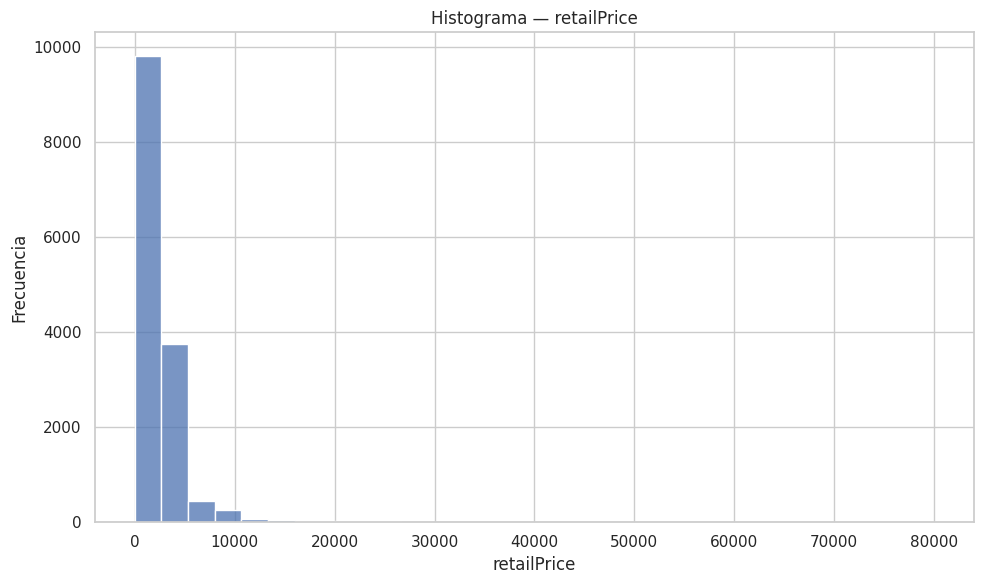

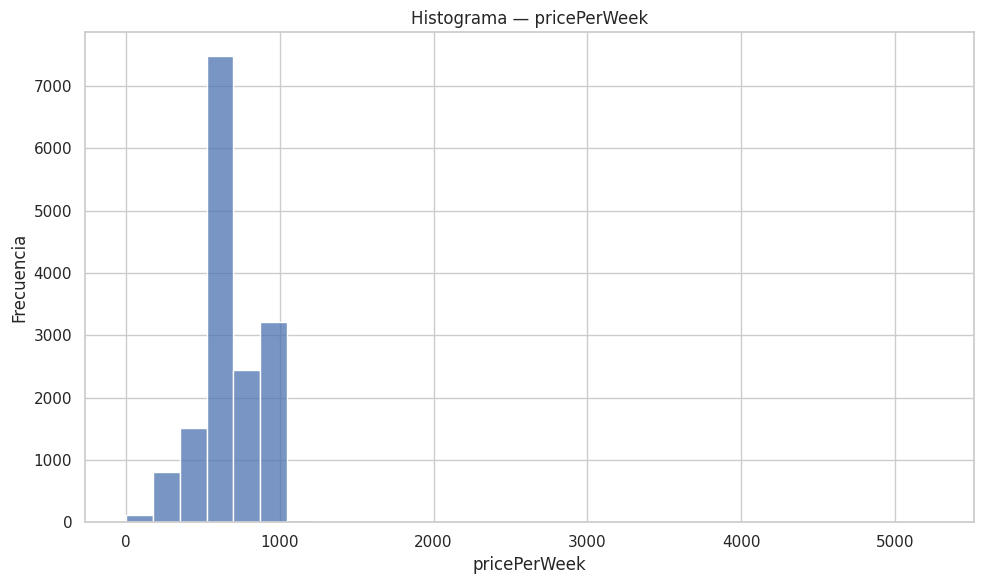

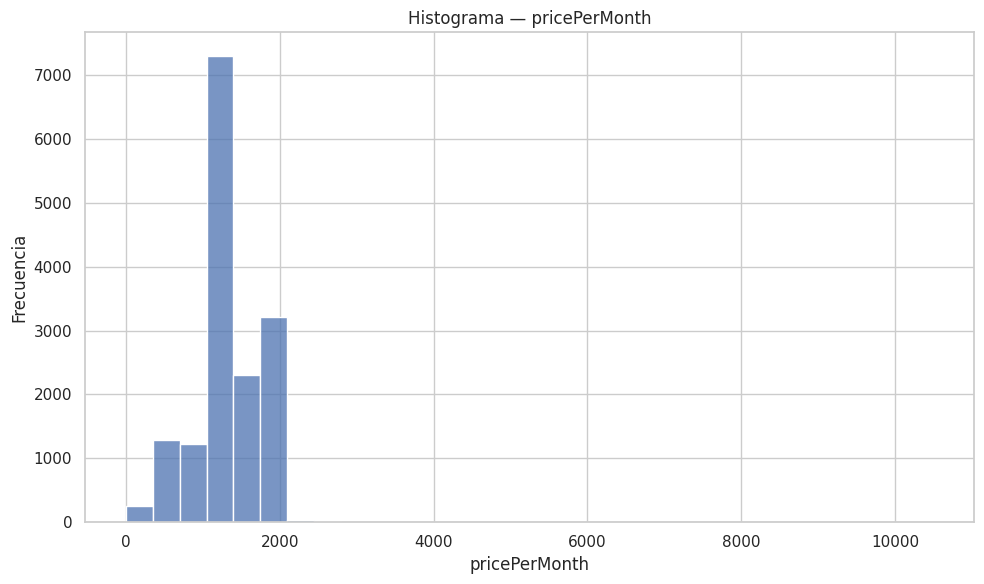

In [28]:
# 6) HISTOGRAMAS DE PRECIOS
for col in cols_precios:
    datos = pd.to_numeric(df[col], errors='coerce').dropna()
    plt.figure()
    sns.histplot(datos, bins=30, kde=False)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.savefig(f'fig_hist_{col}.png', dpi=150, bbox_inches='tight')
    plt.show()


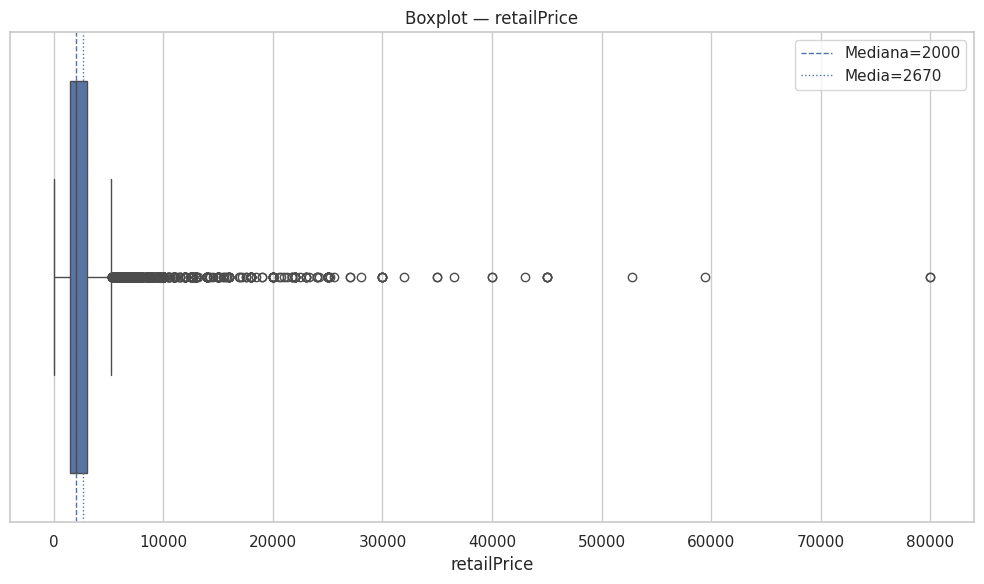

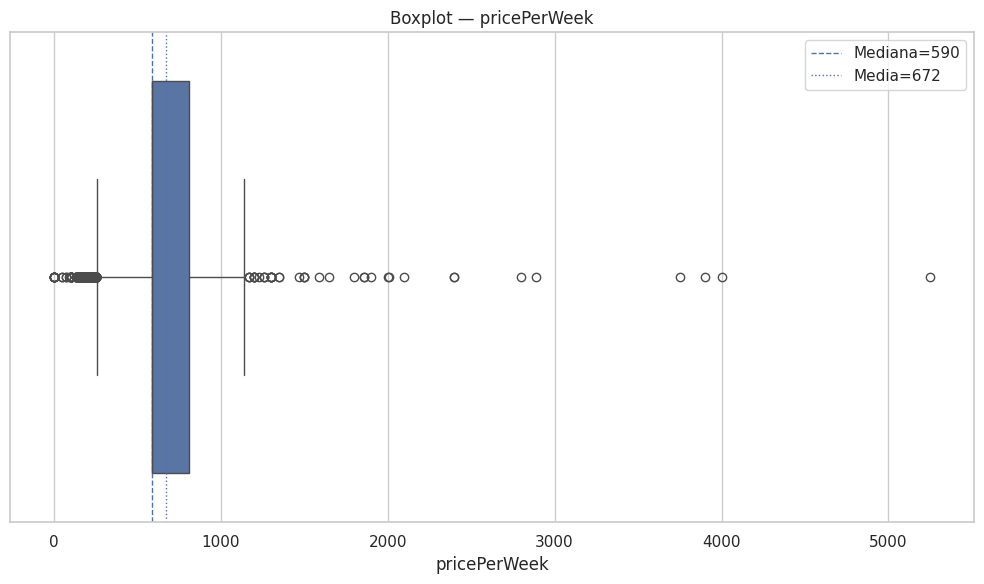

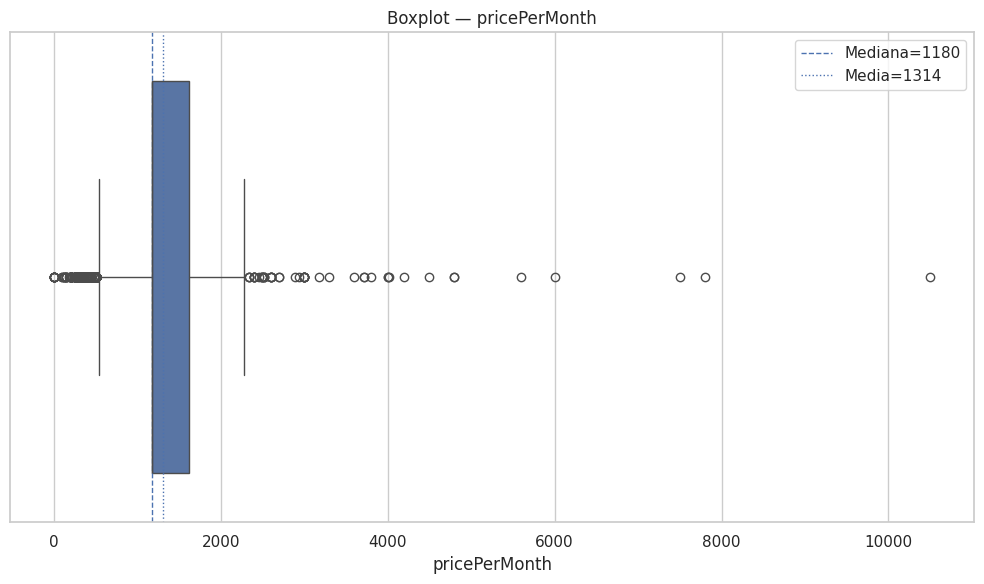

In [29]:
# 7) BOXPLOTS DE PRECIOS
for col in cols_precios:
    x = pd.to_numeric(df[col], errors='coerce').dropna()
    plt.figure()
    sns.boxplot(x=x, whis=1.5, showfliers=True)
    med, mean = x.median(), x.mean()
    plt.axvline(med, linestyle='--', linewidth=1, label=f"Mediana={med:.0f}")
    plt.axvline(mean, linestyle=':', linewidth=1, label=f"Media={mean:.0f}")
    plt.legend()
    plt.title(f"Boxplot — {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.savefig(f'fig_box_{col}.png', dpi=150, bbox_inches='tight')
    plt.show()


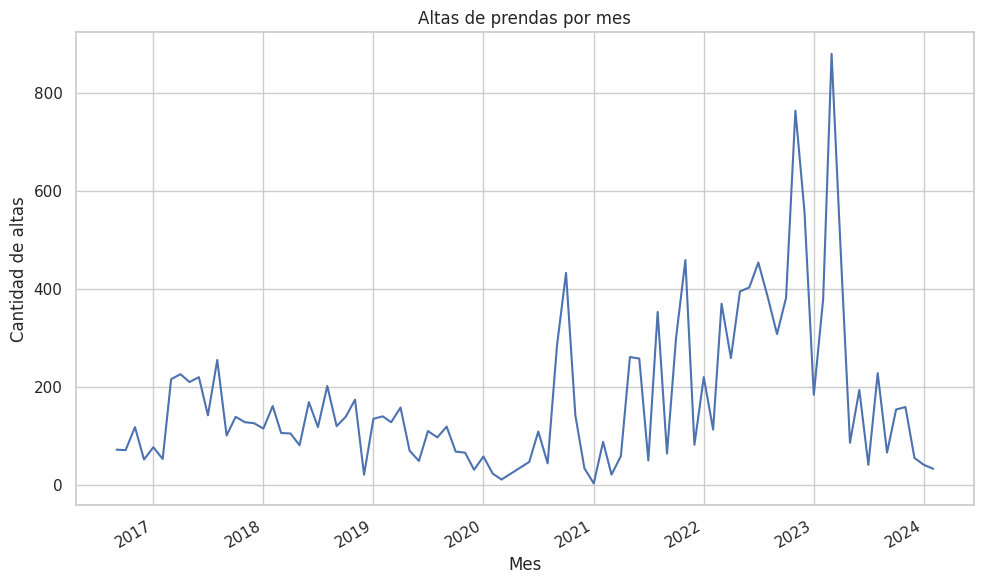

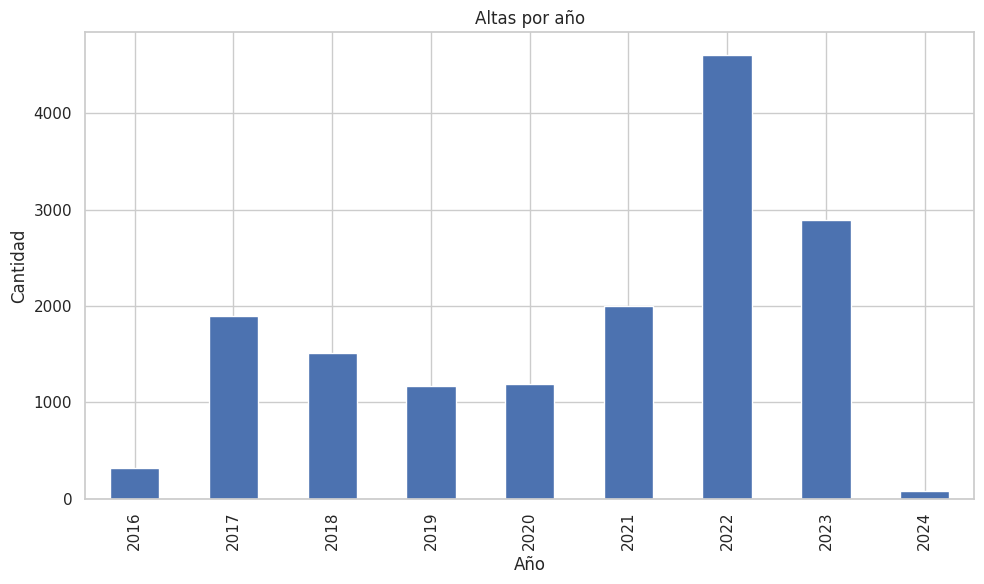

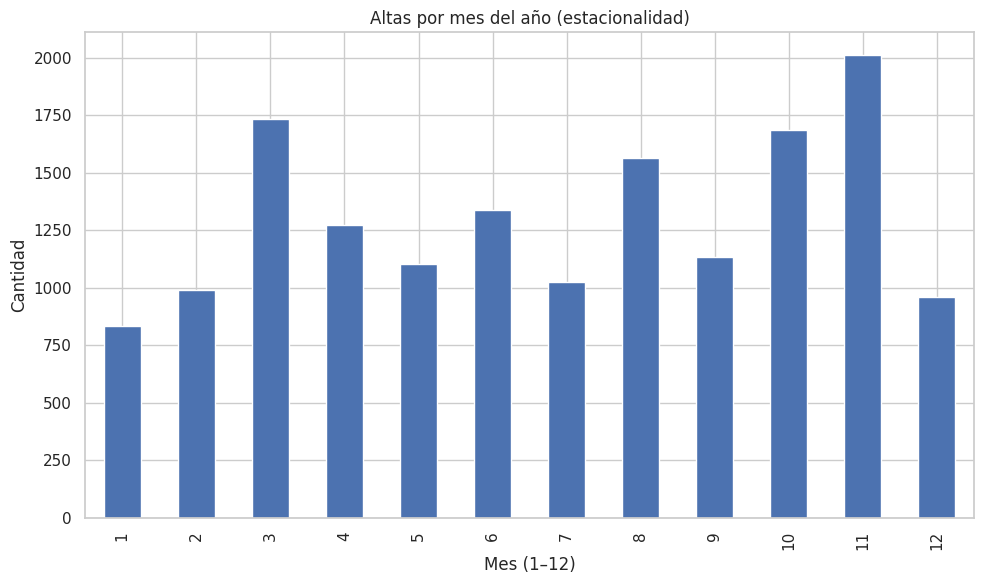

,altas,crecimiento_YoY_%
anio,,
2016,313,NaN
2017,1893,504.80
2018,1511,-20.20
2019,1171,-22.50
2020,1185,1.20
2021,1998,68.60
2022,4611,130.80
2023,2893,-37.30
2024,74,-97.40


In [30]:
# 8) ALTAS POR MES (DINÁMICA TEMPORAL)
d = df.dropna(subset=['timeCreated']).copy()
d['mes'] = d['timeCreated'].dt.to_period('M').dt.to_timestamp()
altas_mensuales = d.groupby('mes').size().rename('altas')

plt.figure()
altas_mensuales.plot()
plt.title("Altas de prendas por mes")
plt.xlabel("Mes"); plt.ylabel("Cantidad de altas")
plt.tight_layout()
plt.savefig('fig_altas_mensuales.png', dpi=150, bbox_inches='tight')
plt.show()

# Barras por AÑO y por MES del año (estacionalidad)
d['anio'] = d['timeCreated'].dt.year
d['mes_num'] = d['timeCreated'].dt.month

plt.figure()
d.groupby('anio').size().plot(kind='bar')
plt.title("Altas por año"); plt.xlabel("Año"); plt.ylabel("Cantidad")
plt.tight_layout(); plt.savefig('fig_altas_anio.png', dpi=150); plt.show()

plt.figure()
d.groupby('mes_num').size().plot(kind='bar')
plt.title("Altas por mes del año (estacionalidad)")
plt.xlabel("Mes (1–12)"); plt.ylabel("Cantidad")
plt.tight_layout(); plt.savefig('fig_altas_mes.png', dpi=150); plt.show()

# Crecimiento YoY
altas_anio = d.groupby('anio').size().rename('altas')
crec_yoy = altas_anio.pct_change()*100
display(pd.DataFrame({'altas': altas_anio, 'crecimiento_YoY_%': crec_yoy.round(1)}))


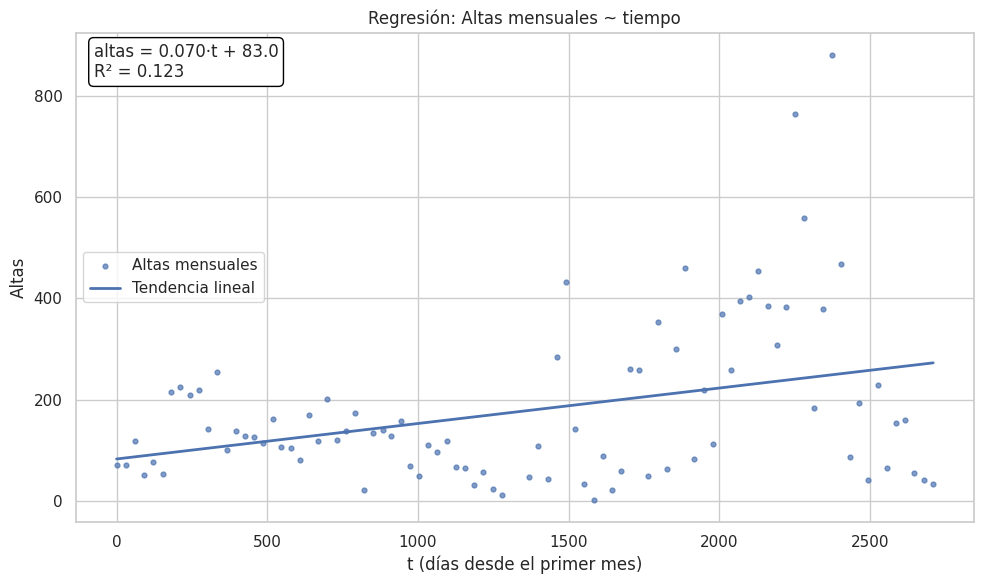

{'variable': 'altas_mensuales', 'beta_1_pendiente': 0.07000900086549929, 'R2': 0.12342045069708951}


In [31]:
# 9) REGRESIÓN: ALTAS MENSUALES ~ TIEMPO
serie = altas_mensuales.reset_index()
serie['t_dias'] = (serie['mes'] - serie['mes'].min()).dt.days
x = serie['t_dias'].to_numpy()
y = serie['altas'].to_numpy()

b1, b0 = np.polyfit(x, y, 1)
yhat = b1*x + b0
ss_res = ((y - yhat)**2).sum()
ss_tot = ((y - y.mean())**2).sum()
r2 = 1 - ss_res/ss_tot

plt.figure()
plt.scatter(x, y, s=12, alpha=0.7, label='Altas mensuales')
plt.plot(x, yhat, linewidth=2, label='Tendencia lineal')
txt = f"altas = {b1:.3f}·t + {b0:.1f}\nR² = {r2:.3f}"
plt.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction', va='top', ha='left',
             bbox=dict(boxstyle='round', fc='white', ec='black'))
plt.title("Regresión: Altas mensuales ~ tiempo")
plt.xlabel("t (días desde el primer mes)"); plt.ylabel("Altas")
plt.legend(); plt.tight_layout()
plt.savefig('fig_reg_altas_tiempo.png', dpi=150, bbox_inches='tight')
plt.show()

print({'variable':'altas_mensuales', 'beta_1_pendiente': float(b1), 'R2': float(r2)})


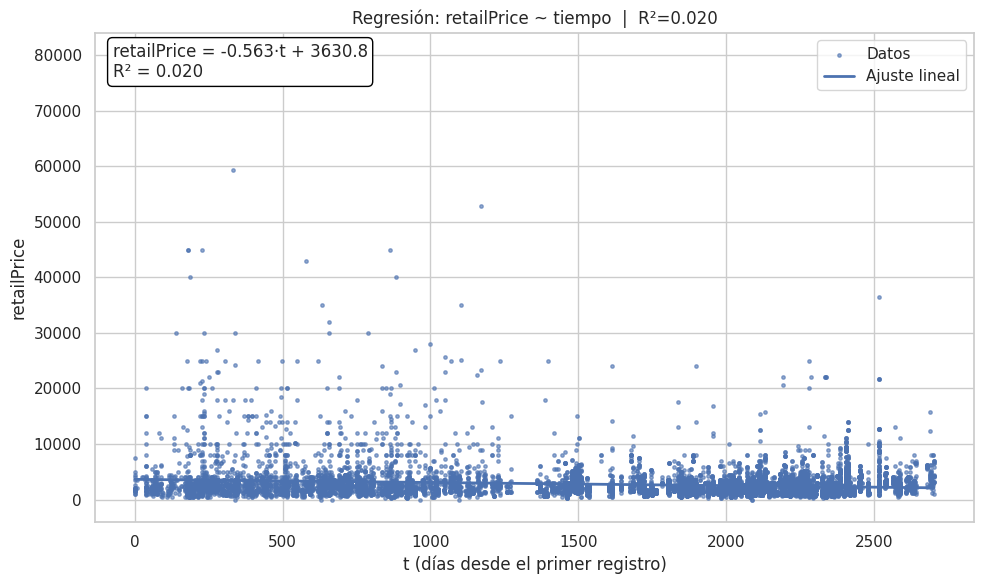

{'variable': 'retailPrice', 'beta_1_pendiente': -0.5627709822045607, 'R2': 0.020396891816246043}


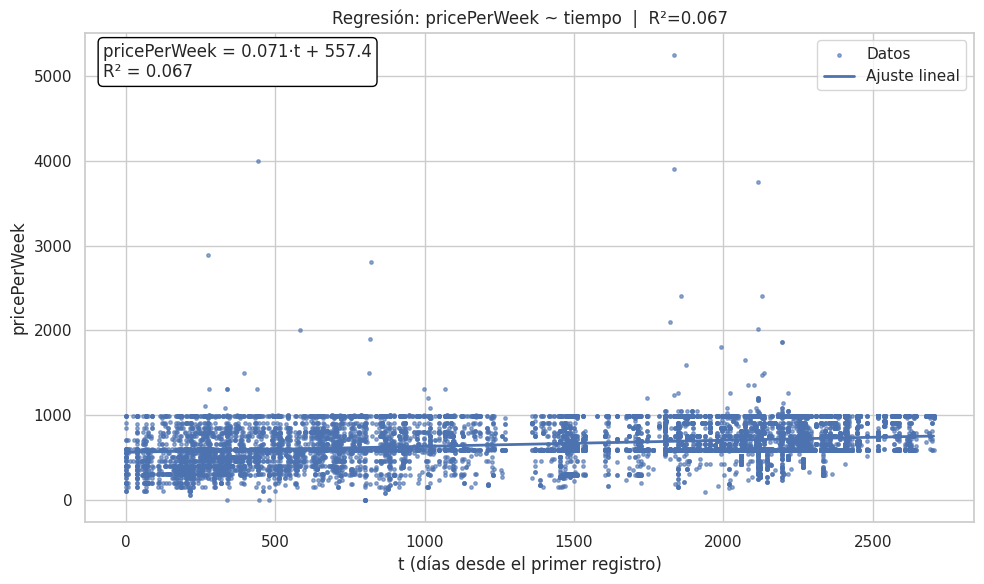

{'variable': 'pricePerWeek', 'beta_1_pendiente': 0.0712284615533058, 'R2': 0.06709369318442615}


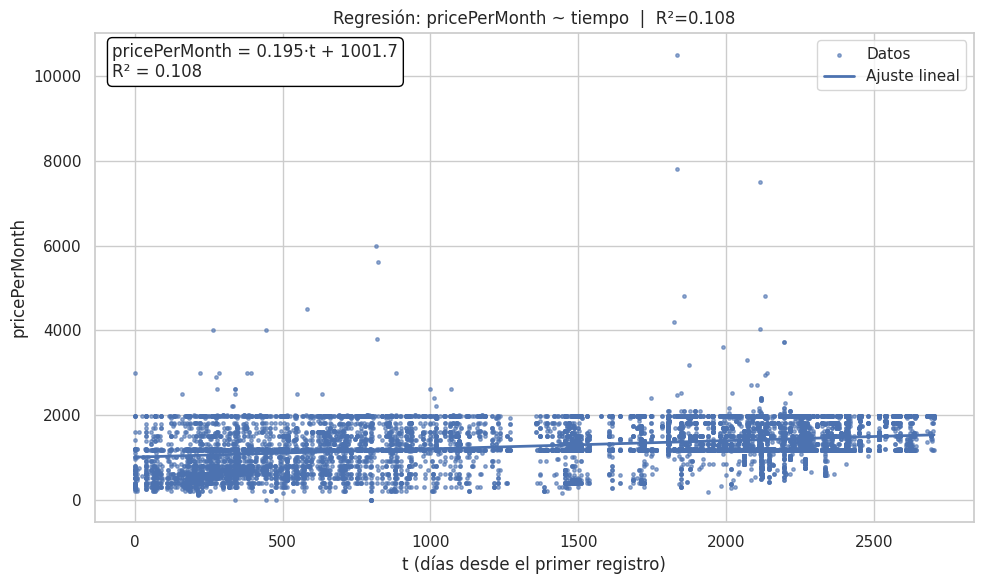

{'variable': 'pricePerMonth', 'beta_1_pendiente': 0.19465823546111588, 'R2': 0.10790780671031919}


In [32]:
# 10) REGRESIÓN: PRECIO ~ TIEMPO (OBLIGATORIO)
def plot_regresion_tiempo(df, col_precio, fname=None):
    d = df.dropna(subset=['timeCreated']).copy().sort_values('timeCreated')
    d['t_dias'] = (d['timeCreated'] - d['timeCreated'].min()).dt.total_seconds()/86400
    x = d['t_dias'].to_numpy()
    y = pd.to_numeric(d[col_precio], errors='coerce').to_numpy()
    ok = ~np.isnan(y); x, y = x[ok], y[ok]
    if len(x) < 2:
        print(f"Datos insuficientes para {col_precio}"); return
    b1, b0 = np.polyfit(x, y, 1); yhat = b1*x + b0
    ss_res = ((y - yhat)**2).sum(); ss_tot = ((y - y.mean())**2).sum()
    r2 = 1 - ss_res/ss_tot if ss_tot!=0 else np.nan
    plt.figure()
    plt.scatter(x, y, s=6, alpha=0.6, label='Datos')
    plt.plot(x, yhat, linewidth=2, label='Ajuste lineal')
    txt = f"{col_precio} = {b1:.3f}·t + {b0:.1f}\nR² = {r2:.3f}"
    plt.annotate(txt, xy=(0.02, 0.98), xycoords='axes fraction',
                 va='top', ha='left', bbox=dict(boxstyle='round', fc='white', ec='black'))
    plt.title(f"Regresión: {col_precio} ~ tiempo  |  R²={r2:.3f}")
    plt.xlabel("t (días desde el primer registro)"); plt.ylabel(col_precio)
    plt.legend(); plt.tight_layout()
    if fname: plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()
    print({'variable': col_precio, 'beta_1_pendiente': float(b1), 'R2': float(r2)})

for col in cols_precios:
    plot_regresion_tiempo(df, col, fname=f"fig_reg_{col}.png")


In [33]:
# 11) TEXTOS AUTOMÁTICOS DE RESULTADOS
print("RESULTADOS — Altas mensuales:")
print("- Revisa 'fig_altas_mensuales.png', 'fig_altas_anio.png', 'fig_altas_mes.png' y la tabla YoY.")
print("- La pendiente de 'fig_reg_altas_tiempo.png' (beta_1) indica si suben (>0) o bajan (<0) las altas.")

print("\nRESULTADOS — Precios:")
print("- Histogramas y boxplots muestran asimetría y outliers en retailPrice; pricePerWeek/Month más compactos.")
print("- Regresiones precio~tiempo: pendientes pequeñas y R² bajos ⇒ el tiempo explica poco los precios.")


RESULTADOS — Altas mensuales:
- Revisa 'fig_altas_mensuales.png', 'fig_altas_anio.png', 'fig_altas_mes.png' y la tabla YoY.
- La pendiente de 'fig_reg_altas_tiempo.png' (beta_1) indica si suben (>0) o bajan (<0) las altas.

RESULTADOS — Precios:
- Histogramas y boxplots muestran asimetría y outliers en retailPrice; pricePerWeek/Month más compactos.
- Regresiones precio~tiempo: pendientes pequeñas y R² bajos ⇒ el tiempo explica poco los precios.



**Referencia**

Borgersen, K. A. K. (2024). Vibrent Clothes Rental Dataset. Kaggle. https://www.kaggle.com/datasets/kaborg15/vibrent-clothes-rental-dataset